<a href="https://colab.research.google.com/github/ashutosh035/Assignments_MscDS/blob/main/202318035_ML_assign_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ML Assignment 8: Decision Tree

###Ashutosh Anand
###202318035


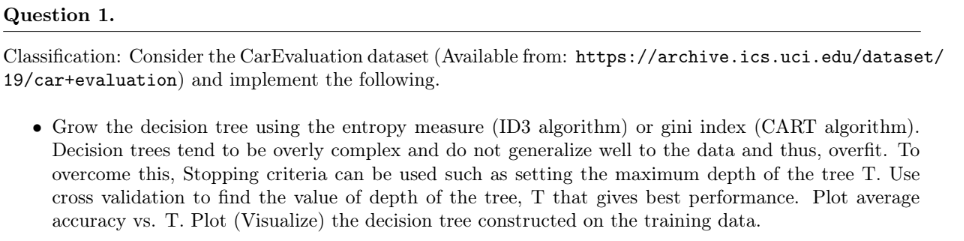

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car_evaluation.data.features
y = car_evaluation.data.targets

# metadata
print(car_evaluation.metadata)

# variable information
print(car_evaluation.variables)

{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

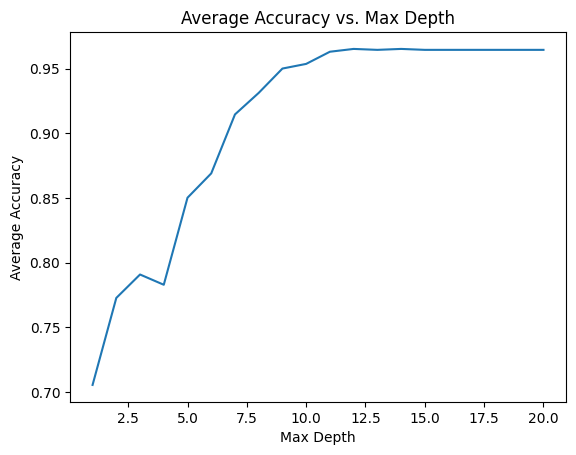

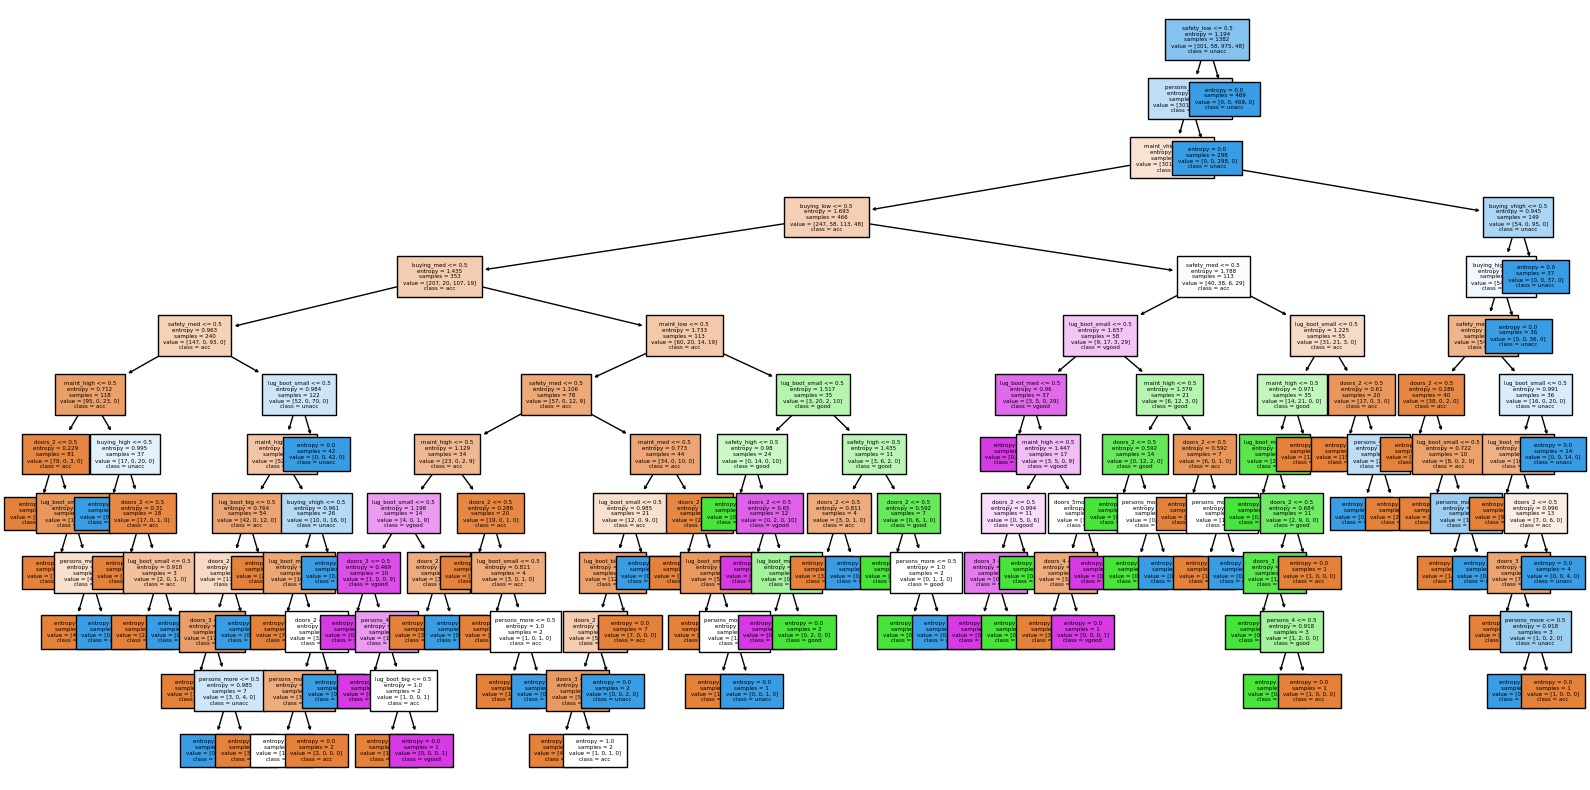

In [ ]:
# Convert categorical variables to numerical
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform cross-validation to find the best max_depth
depths = range(1, 21)
avg_accuracies = []
for depth in depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    avg_accuracy = scores.mean()
    avg_accuracies.append(avg_accuracy)

# Plot average accuracy vs. max_depth
plt.plot(depths, avg_accuracies)
plt.xlabel('Max Depth')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs. Max Depth')
plt.show()

# Train the decision tree with the best max_depth
best_depth = depths[avg_accuracies.index(max(avg_accuracies))]
clf = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, random_state=42)
clf.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, fontsize=4)
plt.show()

In [ ]:
# Find the best max_depth and its corresponding accuracy
best_accuracy = max(avg_accuracies)
best_depth = depths[avg_accuracies.index(best_accuracy)]

print(f"Best accuracy: {best_accuracy:.4f} at depth {best_depth}")

Best accuracy: 0.9653 at depth 12


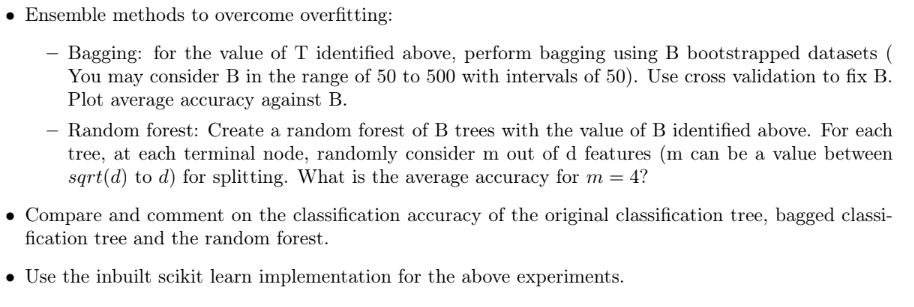

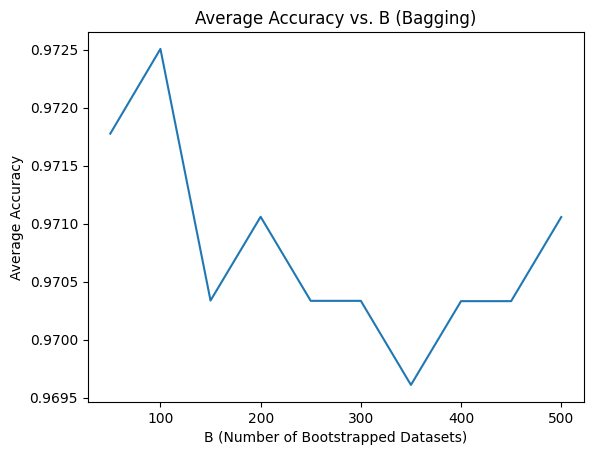

In [ ]:
# Range of B values
Bs = range(50, 501, 50)
avg_accuracies_bagging = []

# Convert y_train to a 1D array
y_train = y_train.values.ravel()

for B in Bs:
    clf_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=best_depth),
                                     n_estimators=B, random_state=42)
    scores_bagging = cross_val_score(clf_bagging, X_train, y_train, cv=5)
    avg_accuracy_bagging = scores_bagging.mean()
    avg_accuracies_bagging.append(avg_accuracy_bagging)


# Plot average accuracy vs. B
plt.plot(Bs, avg_accuracies_bagging)
plt.xlabel('B (Number of Bootstrapped Datasets)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs. B (Bagging)')
plt.show()


In [ ]:
# Find the best max_depth and its corresponding accuracy
best_accuracy_bagging = max(avg_accuracies_bagging)
best_depth_bagging = ((depths[avg_accuracies_bagging.index(best_accuracy_bagging)])*50)

print(f"Best accuracy: {best_accuracy_bagging:.4f} at B {best_depth_bagging}")

Best accuracy: 0.9725 at B 100


In [ ]:
# Define the range of m values
d = X_train.shape[1]
m_values = np.arange(int(np.sqrt(d)), d+1)

# Create a Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=best_depth_bagging, random_state=42)

# Perform grid search over the m values
param_grid = {'max_features': m_values}
grid_search = GridSearchCV(clf_rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best m value
best_m = grid_search.best_params_['max_features']
print("Best value of m:", best_m)

# Calculate the average accuracy for the best m value
clf_rf_best = grid_search.best_estimator_
scores_rf_best = cross_val_score(clf_rf_best, X_train, y_train, cv=5)
avg_accuracy_rf_best = scores_rf_best.mean()
print("Average accuracy for the best m value:", avg_accuracy_rf_best)


Best value of m: 17
Average accuracy for the best m value: 0.9732276461047455


In [ ]:
# Create a Random Forest with B trees and max_features=4
clf_rf = RandomForestClassifier(n_estimators=best_depth_bagging, max_features=best_m, random_state=42)
scores_rf = cross_val_score(clf_rf, X_train, y_train, cv=5)
avg_accuracy_rf = scores_rf.mean()

print(f"Average accuracy for m={best_m}:", avg_accuracy_rf)

Average accuracy for m=17: 0.9732276461047455


In [ ]:
# Evaluate the original classification tree on the test set
original_tree_pred = clf.predict(X_test)
original_tree_accuracy = accuracy_score(y_test, original_tree_pred)

# Train the bagged classification tree with the best B and evaluate on the test set
best_bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth, random_state=42),
                                     n_estimators=best_depth_bagging, random_state=42)
best_bagging_clf.fit(X_train, y_train)
bagging_pred = best_bagging_clf.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_pred)

# Train the random forest with the best B and evaluate on the test set
best_random_forest_clf = RandomForestClassifier(n_estimators=best_depth_bagging, max_features=4, max_depth=best_depth, random_state=42)
best_random_forest_clf.fit(X_train, y_train)
random_forest_pred = best_random_forest_clf.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, random_forest_pred)

# Print the accuracies
print("Classification Accuracy of Original Classification Tree:", original_tree_accuracy)
print("Classification Accuracy of Bagged Classification Tree:", bagging_accuracy)
print("Classification Accuracy of Random Forest:", random_forest_accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification Accuracy of Original Classification Tree: 0.9653179190751445
Classification Accuracy of Bagged Classification Tree: 0.9653179190751445
Classification Accuracy of Random Forest: 0.9595375722543352


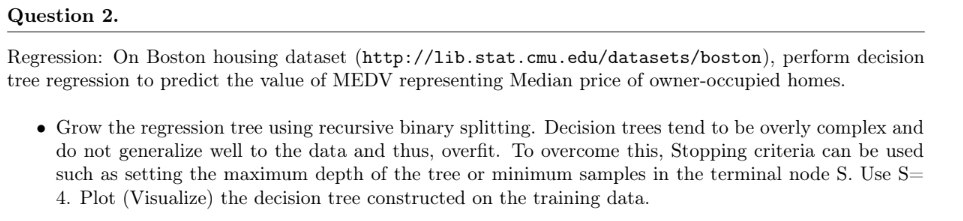

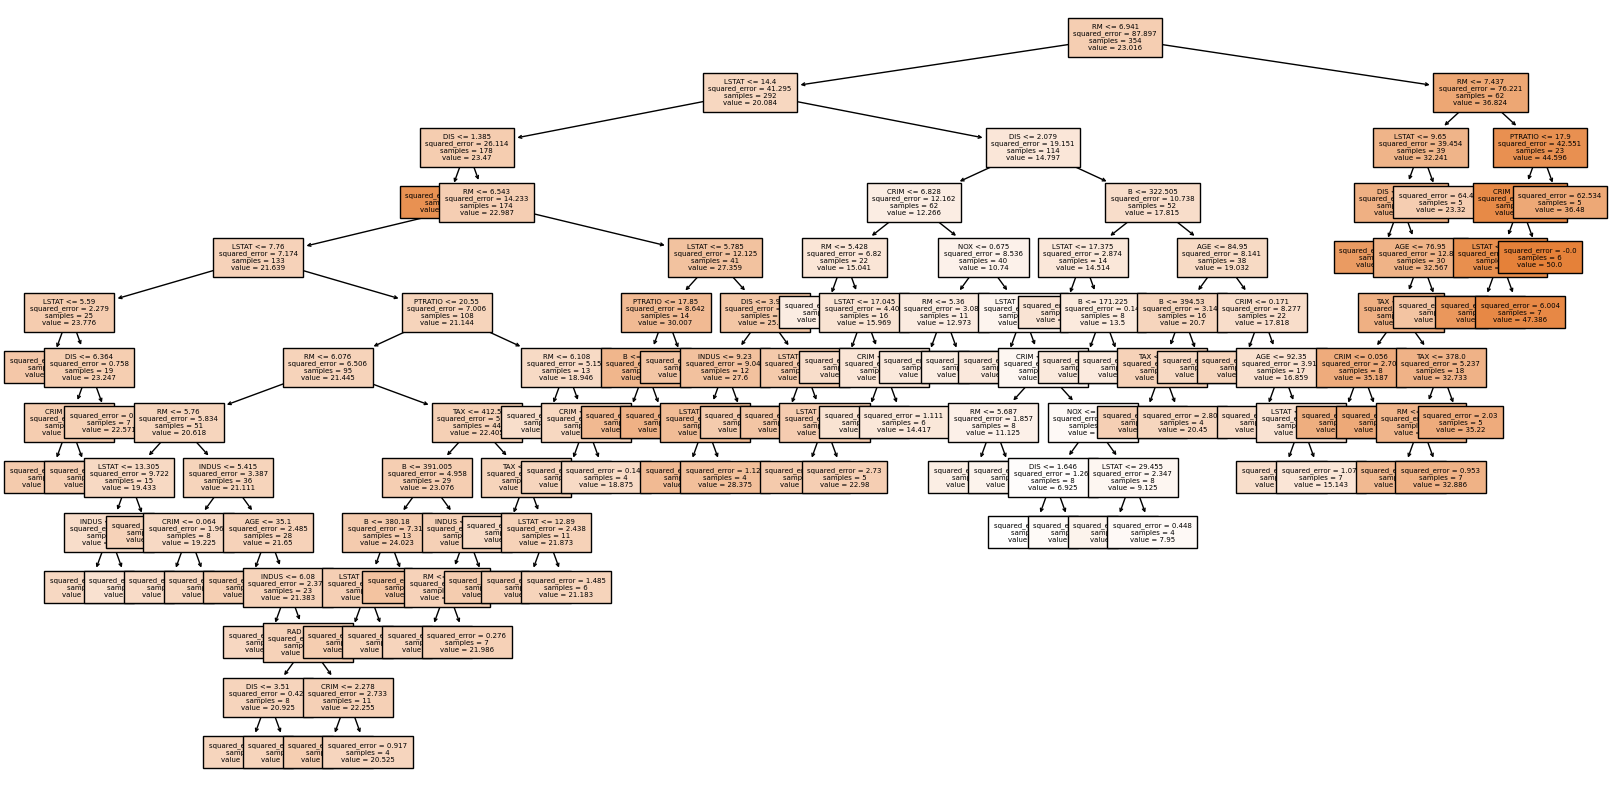

In [ ]:
# Fetch the Boston housing dataset from the original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

# Train a decision tree regressor
regressor = DecisionTreeRegressor(min_samples_leaf=4, random_state=42)
regressor.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(regressor, filled=True, feature_names=[
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
], fontsize=5)
plt.show()


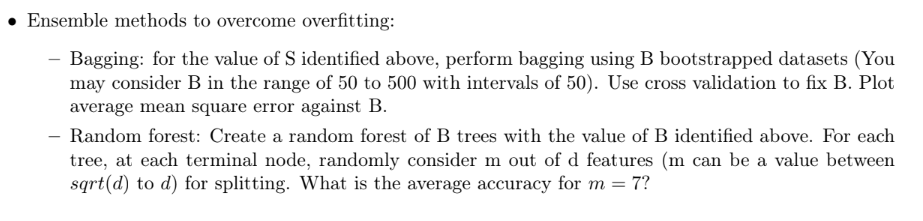

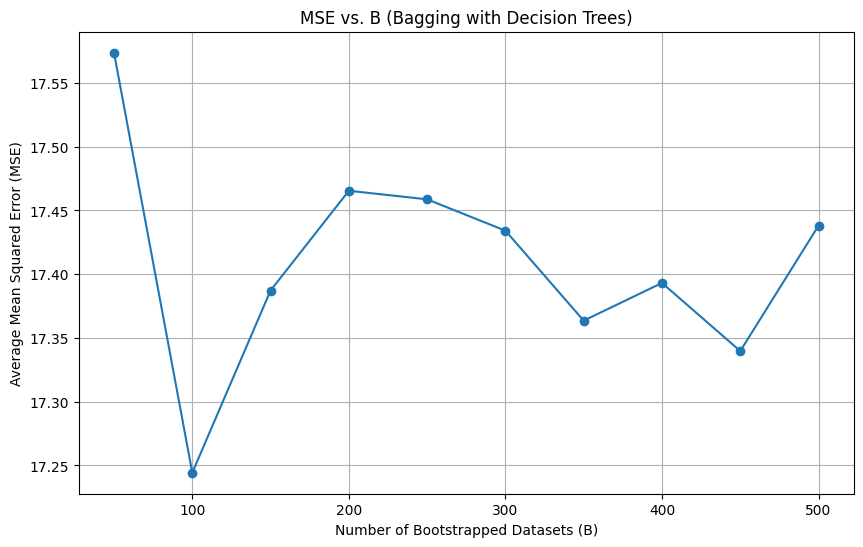

In [ ]:
# Fetch the Boston housing dataset from the original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

# Base estimator: a decision tree regressor with min_samples_leaf=4
estimator = DecisionTreeRegressor(min_samples_leaf=4, random_state=42)

# Range of B values
B_values = range(50, 501, 50)
mse_scores = []

# Perform bagging and cross-validation
for B in B_values:
    bagging_regressor = BaggingRegressor(estimator=estimator, n_estimators=B, random_state=42)
    scores = -cross_val_score(bagging_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(np.mean(scores))

# Plot average MSE against B
plt.figure(figsize=(10, 6))
plt.plot(B_values, mse_scores, marker='o')
plt.xlabel('Number of Bootstrapped Datasets (B)')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('MSE vs. B (Bagging with Decision Trees)')
plt.grid(True)
plt.show()


In [ ]:
# Find the value of B with the lowest MSE
min_mse = min(mse_scores)
optimal_B = B_values[mse_scores.index(min_mse)]

print(f"The optimal value of B is {optimal_B} with a mean squared error of {min_mse:.4f}.")

The optimal value of B is 100 with a mean squared error of 17.2443.


In [ ]:
# Create a random forest with the optimal value of B
random_forest = RandomForestRegressor(n_estimators=optimal_B, random_state=42)
random_forest.fit(X_train, y_train)

# Evaluate the random forest for m = 7
random_forest_m7 = RandomForestRegressor(n_estimators=optimal_B, max_features=7, random_state=42)
random_forest_m7.fit(X_train, y_train)
mse_m7 = mean_squared_error(y_test, random_forest_m7.predict(X_test))
print(f"Mean Squared Error for m = 7: {mse_m7:.4f}")

# Find the best value of m
best_mse = float('inf')
best_m = None
for m in range(int(np.sqrt(X_train.shape[1])), X_train.shape[1] + 1):
    random_forest_m = RandomForestRegressor(n_estimators=optimal_B, max_features=m, random_state=42)
    random_forest_m.fit(X_train, y_train)
    mse_m = mean_squared_error(y_test, random_forest_m.predict(X_test))
    if mse_m < best_mse:
        best_mse = mse_m
        best_m = m

print(f"The best value of m is {best_m} with a mean squared error of {best_mse:.4f}.")

Mean Squared Error for m = 7: 9.7281
The best value of m is 10 with a mean squared error of 9.3809.


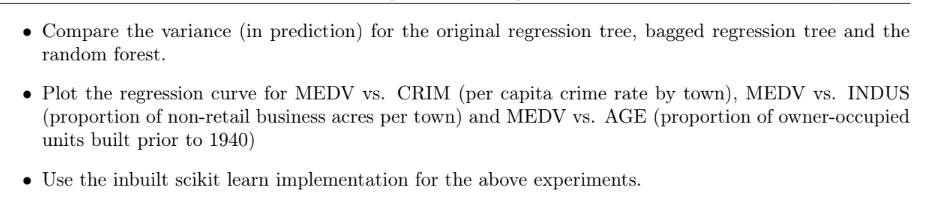

In [ ]:
# Original regression tree predictions
original_tree_predictions = regressor.predict(X_test)

# Bagged regression tree predictions
bagged_tree = BaggingRegressor(estimator=estimator, n_estimators=optimal_B, random_state=42)
bagged_tree.fit(X_train, y_train)
bagged_tree_predictions = bagged_tree.predict(X_test)

# Random forest predictions
random_forest_predictions = random_forest.predict(X_test)

# Calculate variances
variance_original_tree = np.var(original_tree_predictions)
variance_bagged_tree = np.var(bagged_tree_predictions)
variance_random_forest = np.var(random_forest_predictions)

print(f"Variance in predictions for the original regression tree: {variance_original_tree:.4f}")
print(f"Variance in predictions for the bagged regression tree: {variance_bagged_tree:.4f}")
print(f"Variance in predictions for the random forest: {variance_random_forest:.4f}")


Variance in predictions for the original regression tree: 65.4698
Variance in predictions for the bagged regression tree: 57.3525
Variance in predictions for the random forest: 60.5744


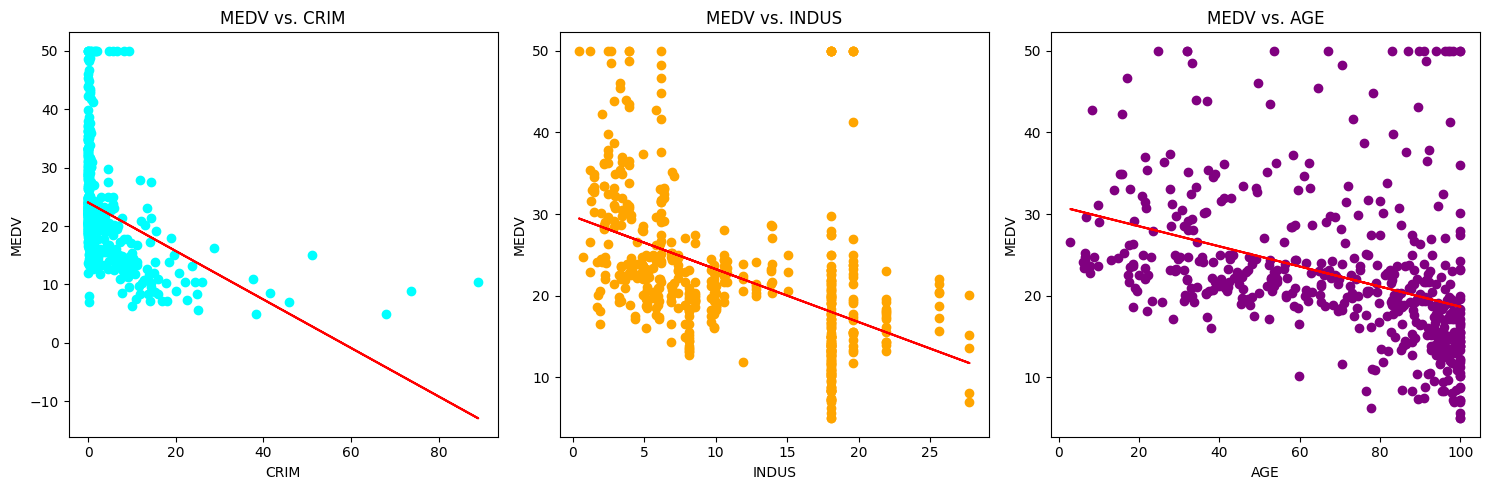

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Fetch the Boston housing dataset from the original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Feature names
feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

# Prepare the data
X = pd.DataFrame(data, columns=feature_names)
y = pd.Series(target, name='MEDV')

# Extracting the relevant columns
X_CRIM = X[['CRIM']].values  # Reshape to maintain 2D array
X_INDUS = X[['INDUS']].values
X_AGE = X[['AGE']].values

# Linear regression model for MEDV vs. CRIM
model_CRIM = LinearRegression()
model_CRIM.fit(X_CRIM, y)
y_pred_CRIM = model_CRIM.predict(X_CRIM)

# Linear regression model for MEDV vs. INDUS
model_INDUS = LinearRegression()
model_INDUS.fit(X_INDUS, y)
y_pred_INDUS = model_INDUS.predict(X_INDUS)

# Linear regression model for MEDV vs. AGE
model_AGE = LinearRegression()
model_AGE.fit(X_AGE, y)
y_pred_AGE = model_AGE.predict(X_AGE)

# Plotting MEDV vs. CRIM
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_CRIM, y, color='blue')
plt.plot(X_CRIM, y_pred_CRIM, color='red')
plt.title('MEDV vs. CRIM')
plt.xlabel('CRIM')
plt.ylabel('MEDV')

# Plotting MEDV vs. INDUS
plt.subplot(1, 3, 2)
plt.scatter(X_INDUS, y, color='orange')
plt.plot(X_INDUS, y_pred_INDUS, color='red')
plt.title('MEDV vs. INDUS')
plt.xlabel('INDUS')
plt.ylabel('MEDV')

# Plotting MEDV vs. AGE
plt.subplot(1, 3, 3)
plt.scatter(X_AGE, y, color='p')
plt.plot(X_AGE, y_pred_AGE, color='red')
plt.title('MEDV vs. AGE')
plt.xlabel('AGE')
plt.ylabel('MEDV')

plt.tight_layout()
plt.show()

MEDV vs. CRIM: The leftmost graph shows a general downward trend, suggesting that as the per capita crime rate increases, the median value of homes tends to decrease. This is consistent with expectations that higher crime rates in an area are generally associated with lower property values. The regression curve also indicates that the strongest relationship is seen in lower CRIM values, with the impact leveling off as CRIM increases, as indicated by the flattening of the curve.

MEDV vs. INDUS: The middle graph indicates a less clear relationship between the proportion of non-retail business acres and median home values. However, there seems to be a general trend where higher INDUS values (more industrial areas) correspond to lower home values. The regression curve zig-zags through the data points, which could suggest that the relationship is not linear and may be influenced by other factors.

MEDV vs. AGE: The rightmost graph shows the relationship between the age of the homes and the median value. There's a lot of variability in the data, and the regression curve does not depict a clear trend. The median value of homes doesn't show a strong dependency on the age of the buildings in this simple view. It could mean that the age of homes, by itself, isn't a strong predictor of home values, or that its effect is complex and possibly non-linear.